# Predicting Tornado Severity From Weather Conditions
## By: Luke Sullivan

---

**Datasets Used**

- Tornado Dataset: [US Tornado Dataset 1950-2021](https://www.kaggle.com/datasets/danbraswell/us-tornado-dataset-1950-2021?resource=download">https://www.kaggle.com/datasets/danbraswell/us-tornado-dataset-1950-2021)

- Weather Dataset: [The Weather Dataset](https://www.kaggle.com/datasets/guillemservera/global-daily-climate-data/data?select=cities.csv)


# Introduction

Tornadoes represent one of the most destructive and unpredictable natural phenomena, causing significant damage to property and endagnering human lives. To better prepare ourselves, understanding the factors that influence tornado severity is crucial for effectice risk mitigation strategies. This research aims to investigate the relationship between weather parameters and tornado data in the United States.

## Background

A tornado's destructiveness is derived largely from the wind speed within it. Meteorologists use the Enhanced Fujita Scale to rate tornadoes based on wind speed, however it is influenced by various weather conditions. The precise relationship with weather conditions and tornadoes remains unclear.

**The Enhanced Fujita Scale**

| Rate | Wind Speed | Damage |
| ----------| ---------| --------- |
| EF0 | 65-85 mph | Light damage |
| EF1 | 86-110 mph |  Moderate damage |
| EF2 | 111-135 mph | Considerable damage |
| EF3 | 136–165 mph | Severe damage |
| EF4 | 166–200 mph | Devastating damage |
| EF5 | >200 mph | Incredible damage |

# Method

## Overview

For this data analysis, I collected 2 datasets that featured tornado data and weather data. I will then merge these datasets based on their date and state to get weather readings on the day of the tornadoes. I will then employ machine learning models known as **Random Forests** and **Support Vector Regression** to collect insights on the effects of weather on tornadoes.

This analysis aims to answer the following research questions:
1. Is there a correlation between annual rainfall levels and tornado frequency within states?2. Can we predict the severity (magnitude, length, width) of tornadoes based on weather conditions?


### Data Collection

- [US Tornado Dataset 1950-2021](https://www.kaggle.com/datasets/danbraswell/us-tornado-dataset-1950-2021?resource=download">https://www.kaggle.com/datasets/danbraswell/us-tornado-dataset-1950-2021)

This dataset features tornado data ranging from 1950-2021 that occurred in the United States of America. It has around 70,000 rows containing various information about tornadoes such as magnitude, location, injuries, and deaths.

| Header | Description |
| ----------| ---------|
| yr | 4-digit year |
| mo | Month (1-12) |
| dy | Day of month |
| date | Datetime object (e.g. 2020-01-01)
| st | State where tornado originated |
| mag | Enhanced Fujita Scale rating |
| inj | Number of injuries |
| fat | Number of fatalities |
| slat | Starting latitude |
| slon | Starting longitude |
| elat | Ending latitude |
| elon | Ending longitude |
| len | length of track (mi) |
| wid | Width (yds) |

- [The Weather Dataset](https://www.kaggle.com/datasets/guillemservera/global-daily-climate-data/data?select=cities.csv)

This dataset contains weather readings since 1833 (and is actively being updated every Sunday!) from all over the world. It contains about 30 million rows and has weather data such as precipitation, temperature, and wind speeds.

| Header | Description |
| ----------| ---------|
| temperature | average, min, max |
| location | lon, lat, state, country of weather station |
| precipitation | calculated in mm |
| wind speed | calculated in kph |
| Date | Exact date and season |

## Data Cleaning

In [1]:
#imports
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.stats import mstats
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, RobustScaler
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from sklearn.decomposition import PCA


standard_scaler = MinMaxScaler()
label_encoder = LabelEncoder()

## Tornado Dataset

In [2]:
#load data in dataframe
data = pd.read_csv("us_tornado_dataset_1950_2021.csv");
data.head(3)

,yr,mo,dy,date,st,mag,inj,fat,slat,slon,elat,elon,len,wid
0,1950,1,3,1950-01-03,IL,3,3,0,39.10,-89.30,39.12,-89.23,3.6,130
1,1950,1,3,1950-01-03,MO,3,3,0,38.77,-90.22,38.83,-90.03,9.5,150
2,1950,1,3,1950-01-03,OH,1,1,0,40.88,-84.58,0.00,0.00,0.1,10


In [3]:
data.describe()

,yr,mo,dy,mag,inj,fat,slat,slon,elat,elon,len,wid
count,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000
mean,1991.341618,5.976761,15.921016,0.691273,1.437876,0.090470,37.142412,-92.784618,22.730695,-56.245590,3.478340,106.577030
std,19.330015,2.438192,8.736773,1.283375,18.263956,1.484106,5.093979,8.689103,18.588638,45.489157,8.278775,205.802676
min,1950.000000,1.000000,1.000000,-9.000000,0.000000,0.000000,17.721200,-163.530000,0.000000,-163.530000,0.000000,0.000000
25%,1976.000000,4.000000,8.000000,0.000000,0.000000,0.000000,33.220000,-98.450000,0.000000,-94.709800,0.100000,20.000000
50%,1994.000000,6.000000,16.000000,1.000000,0.000000,0.000000,37.030000,-93.600000,32.480000,-84.420000,0.800000,50.000000
75%,2008.000000,7.000000,24.000000,1.000000,0.000000,0.000000,40.930000,-86.730000,38.610000,0.000000,3.130000,100.000000
max,2021.000000,12.000000,31.000000,5.000000,1740.000000,158.000000,61.020000,-64.715100,61.020000,0.000000,234.700000,4576.000000


In [4]:
print("########DATA SHAPE########")
print(data.shape)
print("########DATA TYPES########")
print(data.dtypes)

########DATA SHAPE########
(67558, 14)
########DATA TYPES########
yr        int64
mo        int64
dy        int64
date     object
st       object
mag       int64
inj       int64
fat       int64
slat    float64
slon    float64
elat    float64
elon    float64
len     float64
wid       int64
dtype: object


In [5]:
data['date'] = pd.to_datetime(data['date'])

### Filling Missing Values

After exploring the data, It was apparent that all the tornadoes that had a missing magnitude (-9 as stated by the Kaggle author) all had injuries and deaths at 0.

In [6]:
#Data says that magnitutde is filled with "-9" for unknown ratings. (from Kaggle dataset author)
print("Missing mag count:", data.mag[data.mag==-9].count())
print("Missing mag compared to total rows: ", data.mag[data.mag==-9].count() / data.shape[0])
oldmag = data[(data['mag'] == -9) & (data['inj'] == 0) & (data['fat'] == 0)]
total_rows = oldmag.shape[0]
print("Total rows where magnitude is -9 and both injuries and deaths are 0:", total_rows)

Missing mag count: 605
Missing mag compared to total rows:  0.008955268065958139
Total rows where magnitude is -9 and both injuries and deaths are 0: 605


In [7]:
data['mag'] = data['mag'].replace(-9, 0)
print("Missing mag count:", data.mag[data.mag==-9].count())
#replaced the -9 missing value with a magnitude of 0, since the deaths and injuries were all 0 as well.

Missing mag count: 0


In [8]:
print("sLon:", data.slon[data.slon==0].count())
print("sLat:", data.slat[data.slat==0].count())

print("eLon:", data.elon[data.elon==0].count())
print("eLat:", data.elat[data.elat==0].count())

sLon: 0
sLat: 0
eLon: 26363
eLat: 26363


In [9]:
data.loc[data['elon'] == 0, 'elon'] = data.loc[data['elon'] == 0, 'slon']
data.loc[data['elat'] == 0, 'elat'] = data.loc[data['elat'] == 0, 'slat']
#replaced the missing ending longitude and latitude with the starting value

### Label Encoding

Converted state into numerical encoding for preperation for models and analysis.

In [10]:
data['state_encoded'] = label_encoder.fit_transform(data['st'])
data.head(3)

,yr,mo,dy,date,st,mag,inj,fat,slat,slon,elat,elon,len,wid,state_encoded
0,1950,1,3,1950-01-03,IL,3,3,0,39.10,-89.30,39.12,-89.23,3.6,130,14
1,1950,1,3,1950-01-03,MO,3,3,0,38.77,-90.22,38.83,-90.03,9.5,150,24
2,1950,1,3,1950-01-03,OH,1,1,0,40.88,-84.58,40.88,-84.58,0.1,10,35


### Removing Outliers

To remove outliers, I used the process of winsorizing the data, to essentially keep the data but reduce the strength of the outliers to a certain limit. In this case, I chose a limit of 0.025, based on the data.

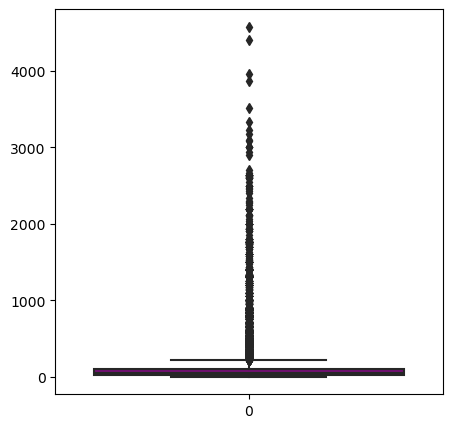

In [11]:
plt.figure(figsize=[5,5])
sns.boxplot(data['wid'], color='purple')
plt.show()

In [12]:
data['len'] = mstats.winsorize(data['len'], limits=[0.025, 0.025])
data['wid'] = mstats.winsorize(data['wid'], limits=[0.025, 0.025])
data['inj'] = mstats.winsorize(data['inj'], limits=[0.025, 0.025])

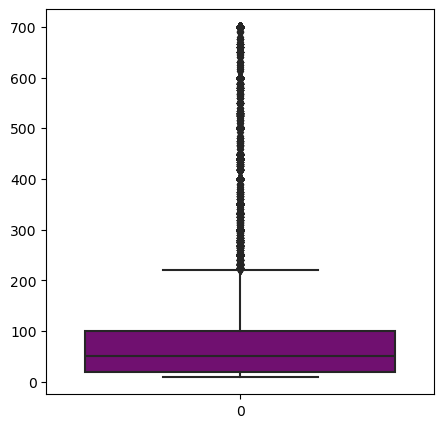

In [13]:
plt.figure(figsize=[5,5])
sns.boxplot(data['wid'], color='purple')
plt.show()

### Transform column names

Renamed column names to be more unified and easier to reference.

In [14]:
column_names = {'yr': 'year', 'mo': 'month', 'dy': 'day', 'st': 'state', 'mag': 'magnitude', 'inj': 'injuries', 'fat': 'deaths', 'len': 'length', 'wid': 'width'}
data.rename(columns=column_names, inplace=True)
data.head(1)

,year,month,day,date,state,magnitude,injuries,deaths,slat,slon,elat,elon,length,width,state_encoded
0,1950,1,3,1950-01-03,IL,3,3,0,39.1,-89.3,39.12,-89.23,3.6,130,14


## Weather Dataset

In [15]:
weather_data = pd.read_parquet('daily_weather.parquet')
city_data = pd.read_csv('weather_cities.csv')
weather_data = pd.merge(weather_data, city_data, on='station_id', how='left')
weather_data.head(3)

,station_id,city_name_x,date,season,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,...,peak_wind_gust_kmh,avg_sea_level_pres_hpa,sunshine_total_min,city_name_y,country,state,iso2,iso3,latitude,longitude
0,41515,Asadabad,1957-07-01,Summer,27.0,21.1,35.6,0.0,NaN,NaN,...,NaN,NaN,NaN,Asadabad,Afghanistan,Kunar,AF,AFG,34.866,71.150005
1,41515,Asadabad,1957-07-02,Summer,22.8,18.9,32.2,0.0,NaN,NaN,...,NaN,NaN,NaN,Asadabad,Afghanistan,Kunar,AF,AFG,34.866,71.150005
2,41515,Asadabad,1957-07-03,Summer,24.3,16.7,35.6,1.0,NaN,NaN,...,NaN,NaN,NaN,Asadabad,Afghanistan,Kunar,AF,AFG,34.866,71.150005


In [16]:
weather_data.shape

(28388191, 21)

In [17]:
weather_data.isnull().sum()

station_id                       0
city_name_x                  13993
date                             0
season                           0
avg_temp_c                 6398423
min_temp_c                 5805123
max_temp_c                 5639866
precipitation_mm           6839728
snow_depth_mm             24860399
avg_wind_dir_deg          24790597
avg_wind_speed_kmh        22901275
peak_wind_gust_kmh        27217953
avg_sea_level_pres_hpa    24209116
sunshine_total_min        27334790
city_name_y                  13993
country                          0
state                       567845
iso2                        130781
iso3                             0
latitude                         0
longitude                        0
dtype: int64

In [18]:
print("USA Count:", weather_data['country'].value_counts().get('United States of America', 0))

USA Count: 1481287


### Resizing the Data

Since this weather dataset contains several countries, I reduced it to just the United States since my otrnado dataset only has data from that country.

In [19]:
weather_data = weather_data[weather_data['country'] == 'United States of America']
weather_data.head(3)

,station_id,city_name_x,date,season,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,...,peak_wind_gust_kmh,avg_sea_level_pres_hpa,sunshine_total_min,city_name_y,country,state,iso2,iso3,latitude,longitude
25761028,72518,Albany,1938-06-01,Summer,NaN,8.3,26.7,0.0,0.0,NaN,...,NaN,NaN,NaN,Albany,United States of America,New York,US,USA,42.670017,-73.819949
25761029,72518,Albany,1938-06-02,Summer,NaN,9.4,26.1,5.1,0.0,NaN,...,NaN,NaN,NaN,Albany,United States of America,New York,US,USA,42.670017,-73.819949
25761030,72518,Albany,1938-06-03,Summer,NaN,13.9,23.3,4.1,0.0,NaN,...,NaN,NaN,NaN,Albany,United States of America,New York,US,USA,42.670017,-73.819949


### Filling Missing Values

For the missing values in the **season** column, I used the month provided in the date column to assign the correct season.

For the **precipitation** and **average windspeed** columns, I grouped the averages based on the specific state and season and filled the corresponding rows with those values. I felt this provided the highest precision in terms of averages about the data.

In [20]:
#Filling NaN season values with corresponding month for each season
month_to_season = {
    1: 'Winter',
    2: 'Winter',
    3: 'Spring',
    4: 'Spring',
    5: 'Spring',
    6: 'Summer',
    7: 'Summer',
    8: 'Summer',
    9: 'Fall',
    10: 'Fall',
    11: 'Fall',
    12: 'Winter'
}

weather_data['month'] = pd.to_datetime(weather_data['date']).dt.month
weather_data['season'] = weather_data['season'].fillna(weather_data['month'].map(month_to_season))
weather_data.drop(columns=['month'], inplace=True)

print("---")
print("Total NaN in Season:", weather_data.season.isnull().sum())

---
Total NaN in Season: 0


In [21]:
weather_data.precipitation_mm.isnull().sum()

23241

In [22]:
precip_avg = weather_data.dropna(subset=['precipitation_mm']).groupby(['state', 'season'])['precipitation_mm'].mean()

In [23]:
weather_data.isnull().sum()

station_id                      0
city_name_x                     0
date                            0
season                          0
avg_temp_c                 545686
min_temp_c                   2584
max_temp_c                   2526
precipitation_mm            23241
snow_depth_mm              177509
avg_wind_dir_deg          1024517
avg_wind_speed_kmh         532918
peak_wind_gust_kmh        1048359
avg_sea_level_pres_hpa     617464
sunshine_total_min         971919
city_name_y                     0
country                         0
state                           0
iso2                            0
iso3                            0
latitude                        0
longitude                       0
dtype: int64

In [24]:
weather_data['avg_wind_speed_kmh'] = weather_data.groupby(['state', 'season'])['avg_wind_speed_kmh'].transform(lambda x: x.fillna(x.mean()))
weather_data.isnull().sum()

station_id                      0
city_name_x                     0
date                            0
season                          0
avg_temp_c                 545686
min_temp_c                   2584
max_temp_c                   2526
precipitation_mm            23241
snow_depth_mm              177509
avg_wind_dir_deg          1024517
avg_wind_speed_kmh              0
peak_wind_gust_kmh        1048359
avg_sea_level_pres_hpa     617464
sunshine_total_min         971919
city_name_y                     0
country                         0
state                           0
iso2                            0
iso3                            0
latitude                        0
longitude                       0
dtype: int64

In [25]:
weather_data = pd.merge(weather_data, precip_avg.reset_index(), on=['state', 'season'], how='left', suffixes=('','_avg'))
weather_data['precipitation_mm'].fillna(weather_data['precipitation_mm_avg'], inplace=True)
weather_data.drop(columns=['precipitation_mm_avg'], inplace=True)

drop_columns = ['country', 'iso2', 'iso3', 'latitude', 'longitude', 'station_id', 'sunshine_total_min', 'avg_sea_level_pres_hpa',
               'peak_wind_gust_kmh', 'avg_wind_dir_deg', 'snow_depth_mm', 'city_name_x', 'city_name_y']
weather_data.drop(columns=drop_columns, inplace=True)

weather_data.head(3)

,date,season,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_wind_speed_kmh,state
0,1938-06-01,Summer,NaN,8.3,26.7,0.0,11.139388,New York
1,1938-06-02,Summer,NaN,9.4,26.1,5.1,11.139388,New York
2,1938-06-03,Summer,NaN,13.9,23.3,4.1,11.139388,New York


In [26]:
avg_temps = weather_data.groupby('season')[['min_temp_c', 'max_temp_c']].median()

for season, avg_temp_row in avg_temps.iterrows():
    weather_data.loc[weather_data['season'] == season, 'min_temp_c'] = weather_data.loc[weather_data['season'] == season, 'min_temp_c'].fillna(avg_temp_row['min_temp_c'])
    weather_data.loc[weather_data['season'] == season, 'max_temp_c'] = weather_data.loc[weather_data['season'] == season, 'max_temp_c'].fillna(avg_temp_row['max_temp_c'])

weather_data['avg_temp_c'] = weather_data['avg_temp_c'].fillna((weather_data['min_temp_c'] + weather_data['max_temp_c']) / 2)
weather_data.isnull().sum()

date                  0
season                0
avg_temp_c            0
min_temp_c            0
max_temp_c            0
precipitation_mm      0
avg_wind_speed_kmh    0
state                 0
dtype: int64

### Label Encoding

Switched the states from their full name to the abbreviations since that is what is provided from the tornado dataset. This will help with merging the datasets together.

In [27]:
#Switching states to be their abbreviation to match tornado dataset
state_mapping = {
    'Illinois': 'IL', 'Missouri': 'MO', 'Ohio': 'OH', 'Arkansas': 'AR', 'Texas': 'TX',
    'Louisiana': 'LA', 'Mississippi': 'MS', 'Tennessee': 'TN', 'Oklahoma': 'OK', 'Florida': 'FL',
    'Alabama': 'AL', 'South Carolina': 'SC', 'Kansas': 'KS', 'Iowa': 'IA', 'Nebraska': 'NE',
    'South Dakota': 'SD', 'Wyoming': 'WY', 'North Carolina': 'NC', 'Georgia': 'GA', 'North Dakota': 'ND',
    'Minnesota': 'MN', 'Wisconsin': 'WI', 'Indiana': 'IN', 'Pennsylvania': 'PA', 'New Mexico': 'NM',
    'Connecticut': 'CT', 'Colorado': 'CO', 'West Virginia': 'WV', 'Maryland': 'MD', 'Kentucky': 'KY',
    'California': 'CA', 'Virginia': 'VA', 'New Jersey': 'NJ', 'Michigan': 'MI', 'Massachusetts': 'MA',
    'New Hampshire': 'NH', 'Oregon': 'OR', 'New York': 'NY', 'Montana': 'MT', 'Arizona': 'AZ',
    'Utah': 'UT', 'Maine': 'ME', 'Vermont': 'VT', 'Idaho': 'ID', 'Washington': 'WA', 'Delaware': 'DE',
    'Hawaii': 'HI', 'Puerto Rico': 'PR', 'Alaska': 'AK', 'Nevada': 'NV', 'Rhode Island': 'RI',
    'District of Columbia': 'DC', 'Virgin Islands': 'VI'
}

weather_data['state'] = weather_data['state'].map(state_mapping)

print(weather_data.state.unique())

['NY' 'MD' 'GA' 'ME' 'TX' 'ND' 'ID' 'MA' 'NV' 'WV' 'WY' 'SC' 'OH' 'NH'
 'CO' 'IA' 'DE' 'KY' 'PA' 'CT' 'MT' 'HI' 'IN' 'MS' 'MO' 'AK' 'MI' 'NE'
 'AR' 'WI' 'AL' 'VT' 'TN' 'OK' 'WA' 'AZ' 'RI' 'NC' 'VA' 'CA' 'MN' 'OR'
 'UT' 'NM' 'IL' 'FL' 'KS' 'NJ' 'DC']


In [28]:
weather_data.shape

(1481287, 8)

## Merging the Datasets

Now that the data has preprocessed, the datasets will get merged to see the corresponding weather data based on the date and state of the tornado.

In [29]:
tornado_data = pd.merge(data, weather_data, on=['date', 'state'], how='left')
tornado_data.shape

(67558, 21)

In [30]:
tornado_data.head(3)

,year,month,day,date,state,magnitude,injuries,deaths,slat,slon,...,elon,length,width,state_encoded,season,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_wind_speed_kmh
0,1950,1,3,1950-01-03,IL,3,3,0,39.10,-89.30,...,-89.23,3.6,130,14,Winter,4.75,-6.1,15.6,31.5,17.666854
1,1950,1,3,1950-01-03,MO,3,3,0,38.77,-90.22,...,-90.03,9.5,150,24,NaN,NaN,NaN,NaN,NaN,NaN
2,1950,1,3,1950-01-03,OH,1,1,0,40.88,-84.58,...,-84.58,0.1,10,35,Winter,13.20,11.7,17.8,17.5,27.500000


In [31]:
tornado_data.isnull().sum()

year                     0
month                    0
day                      0
date                     0
state                    0
magnitude                0
injuries                 0
deaths                   0
slat                     0
slon                     0
elat                     0
elon                     0
length                   0
width                    0
state_encoded            0
season                6369
avg_temp_c            6369
min_temp_c            6369
max_temp_c            6369
precipitation_mm      6369
avg_wind_speed_kmh    6369
dtype: int64

In [32]:
tornado_data.dtypes

year                           int64
month                          int64
day                            int64
date                  datetime64[ns]
state                         object
magnitude                      int64
injuries                       int64
deaths                         int64
slat                         float64
slon                         float64
elat                         float64
elon                         float64
length                       float64
width                          int64
state_encoded                  int32
season                      category
avg_temp_c                   float64
min_temp_c                   float64
max_temp_c                   float64
precipitation_mm             float64
avg_wind_speed_kmh           float64
dtype: object

### Filling Missing Values

In [33]:
#Fix missing season values
month_to_season = {
    1: 'Winter',
    2: 'Winter',
    3: 'Spring',
    4: 'Spring',
    5: 'Spring',
    6: 'Summer',
    7: 'Summer',
    8: 'Summer',
    9: 'Autumn',
    10: 'Autumn',
    11: 'Autumn',
    12: 'Winter'
}

#filled season with matching month
tornado_data['season'] = tornado_data['season'].fillna(tornado_data['month'].map(month_to_season))

#Fix missing temp and precipitation values by getting average from weather data based off of season and state.
columns_to_fill = ['avg_temp_c', 'min_temp_c', 'max_temp_c', 'precipitation_mm']

for column in columns_to_fill:
    tornado_data[column].fillna(
        weather_data.groupby(['season', 'state'])[column].transform('mean'), inplace=True)

In [34]:
tornado_data['avg_wind_speed_kmh'] = tornado_data.groupby(['state', 'season'])['avg_wind_speed_kmh'].transform(lambda x: x.fillna(x.mean()))

# Group the data by 'season' and calculate the average wind speed for each season
season_avg_wind_speed = tornado_data.groupby('season')['avg_wind_speed_kmh'].mean()

# Fill the remaining null values in 'avg_wind_speed_kmh' with the average wind speed for each season
tornado_data['avg_wind_speed_kmh'] = tornado_data.apply(lambda row: season_avg_wind_speed[row['season']] if pd.isnull(row['avg_wind_speed_kmh']) else row['avg_wind_speed_kmh'], axis=1)

tornado_data.isnull().sum()

year                  0
month                 0
day                   0
date                  0
state                 0
magnitude             0
injuries              0
deaths                0
slat                  0
slon                  0
elat                  0
elon                  0
length                0
width                 0
state_encoded         0
season                0
avg_temp_c            0
min_temp_c            0
max_temp_c            0
precipitation_mm      0
avg_wind_speed_kmh    0
dtype: int64

## Label Encoding

In [35]:
tornado_data['season_encoded'] = label_encoder.fit_transform(tornado_data['season'])

## Normalization Dataset

In [36]:
numeric_columns = ['injuries', 'deaths', 
                   'slat', 'slon', 'elat', 'elon', 'length', 'width', 
                   'state_encoded', 'avg_temp_c', 'min_temp_c', 'max_temp_c', 
                   'precipitation_mm', 'avg_wind_speed_kmh', 'season_encoded']


scaler = MinMaxScaler()
norm_tornado_data = data.copy()
norm_tornado_data[numeric_columns] = scaler.fit_transform(tornado_data[numeric_columns])
norm_tornado_data.head()

,year,month,day,date,state,magnitude,injuries,deaths,slat,slon,...,elon,length,width,state_encoded,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_wind_speed_kmh,season_encoded
0,1950,1,3,1950-01-03,IL,3,0.375,0.000000,0.493750,0.751203,...,0.751911,0.150215,0.173913,0.269231,0.387457,0.212000,0.377176,0.135542,0.339899,1.0
1,1950,1,3,1950-01-03,MO,3,0.375,0.000000,0.486129,0.741892,...,0.743815,0.403433,0.202899,0.461538,0.666650,0.630196,0.600023,0.012921,0.436089,1.0
2,1950,1,3,1950-01-03,OH,1,0.125,0.000000,0.534860,0.798969,...,0.798969,0.000000,0.000000,0.673077,0.532646,0.568000,0.419729,0.075301,0.533465,1.0
3,1950,1,13,1950-01-13,AR,3,0.125,0.006329,0.385202,0.699894,...,0.699894,0.021459,0.010145,0.038462,0.666650,0.630196,0.600023,0.012921,0.218870,1.0
4,1950,1,25,1950-01-25,IL,2,0.000,0.000000,0.541558,0.771139,...,0.771139,0.000000,0.130435,0.269231,0.463058,0.278000,0.483559,0.084337,0.339899,1.0


# Data Exploration

### Total Tornadoes Per Day

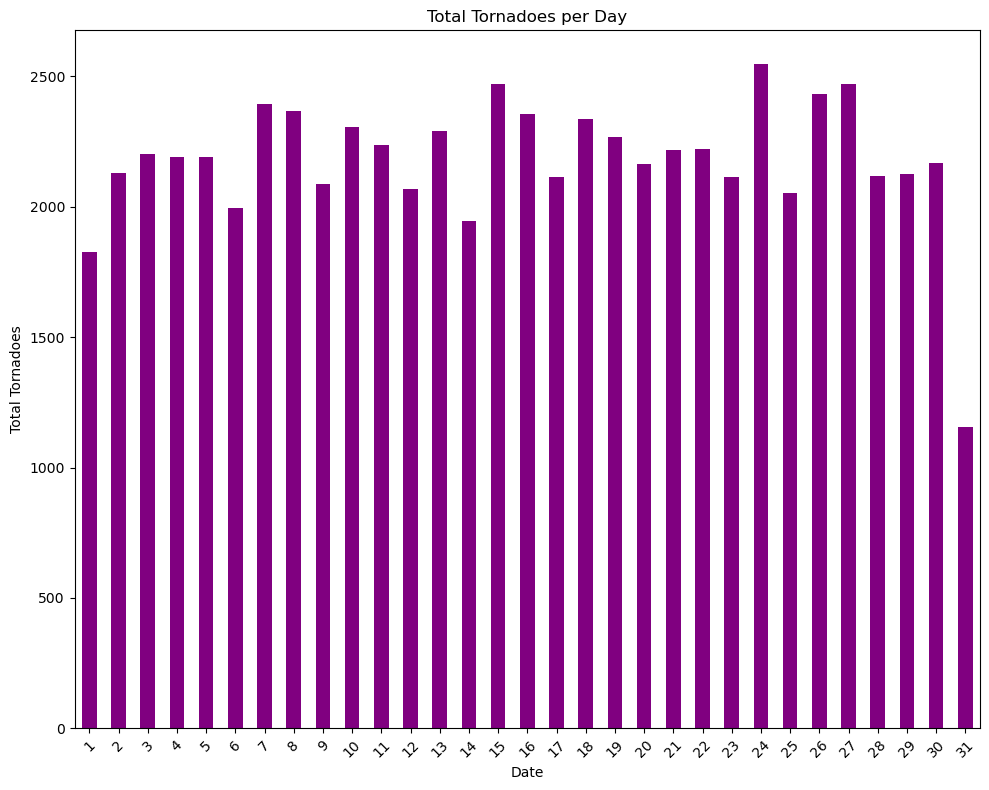

In [37]:
# Group the data by unique days and count the number of tornadoes on each day
tornadoes_per_day = tornado_data.groupby(tornado_data['day']).size()

plt.figure(figsize=(10, 8))
tornadoes_per_day.plot(kind='bar', color='purple')
plt.xlabel('Date')
plt.ylabel('Total Tornadoes')
plt.title('Total Tornadoes per Day')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1000x800 with 0 Axes>

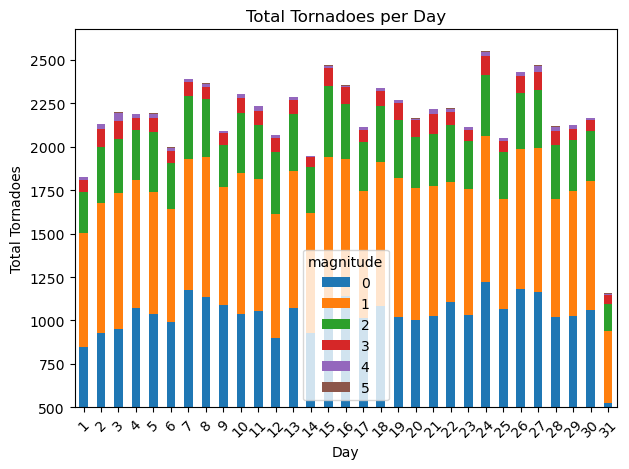

In [38]:
# Pivot the data to have each magnitude as a separate column
tornadoes_per_day_magnitude = tornado_data.pivot_table(index='day', columns='magnitude', aggfunc='size', fill_value=0)

# Sort the columns by total tornadoes per day (optional)
tornadoes_per_day_magnitude = tornadoes_per_day_magnitude.reindex(tornadoes_per_day_magnitude.sum().sort_values(ascending=False).index, axis=1)

# Plot the stacked bar chart
plt.figure(figsize=[10,8])
tornadoes_per_day_magnitude.plot(kind='bar', stacked=True)
plt.xlabel('Day')
plt.ylabel('Total Tornadoes')
plt.title('Total Tornadoes per Day')
plt.xticks(rotation=45)
plt.tight_layout()


plt.gca().set_ylim(bottom=500)

plt.show()

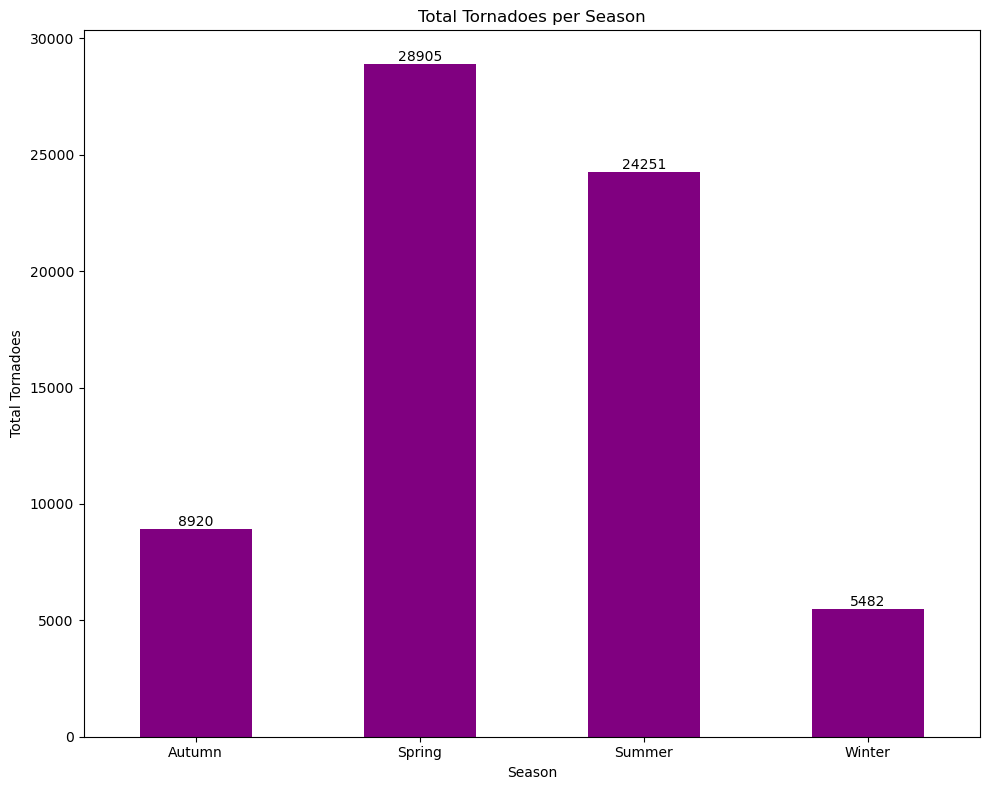

In [39]:
tornadoes_per_season = tornado_data.groupby('season').size()

# Plot the bar chart
plt.figure(figsize=(10, 8))
ax = tornadoes_per_season.plot(kind='bar', color='purple')
plt.xlabel('Season')
plt.ylabel('Total Tornadoes')
plt.title('Total Tornadoes per Season')
plt.xticks(rotation=0)
plt.tight_layout()

# Annotate each bar with its corresponding value
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

### Tornado Count Per Year

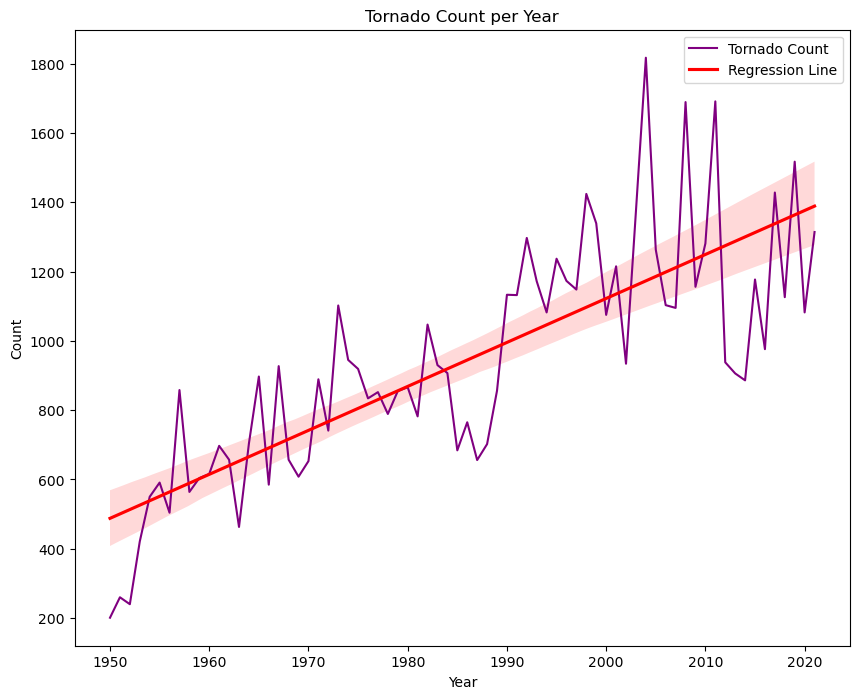

In [40]:
tornado_count = norm_tornado_data.groupby('year').magnitude.count()

plt.figure(figsize=[10, 8])
plt.plot(tornado_count.index, tornado_count, color='purple', label='Tornado Count')
sns.regplot(x=tornado_count.index, y=tornado_count, scatter=False, color='red', label='Regression Line') 
plt.title('Tornado Count per Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.show()

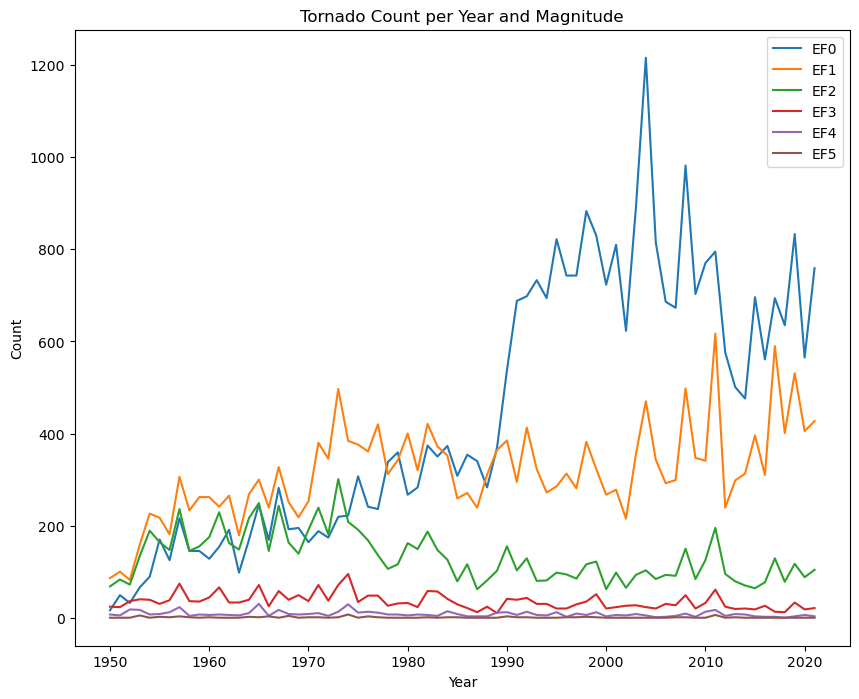

In [41]:
tornado_counts = norm_tornado_data.groupby(['year', 'magnitude']).size().unstack(fill_value=0)

x = tornado_counts.index.values

plt.figure(figsize=[10, 8])

for magnitude in range(0, 6):
    y = tornado_counts[magnitude].values
    plt.plot(x, y, label=f'EF{magnitude}')

plt.title('Tornado Count per Year and Magnitude')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.show()

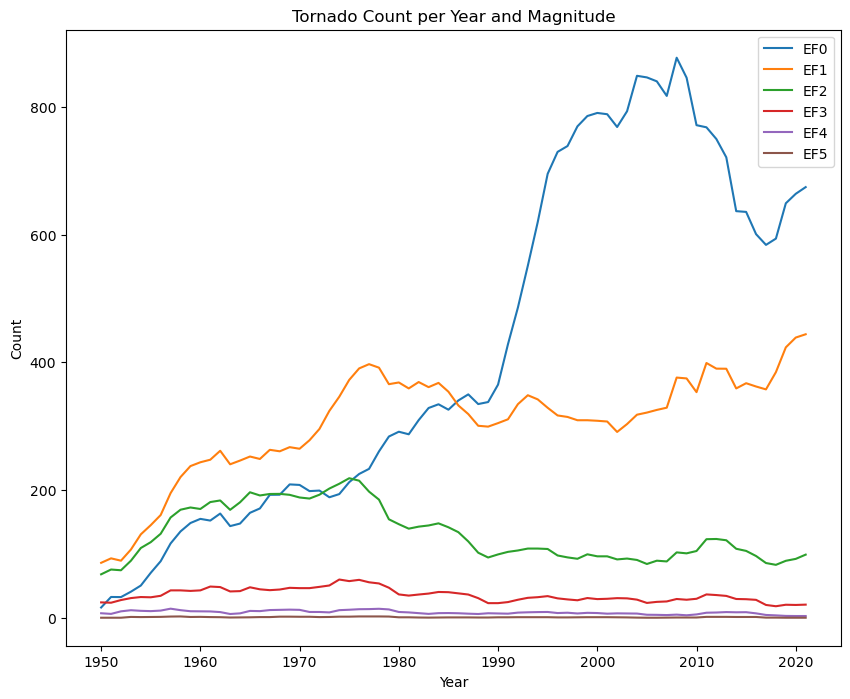

In [42]:
rolling_avg = tornado_counts.rolling(window=6, min_periods=1).mean()

x = rolling_avg.index.values

plt.figure(figsize=[10, 8])

# Plot each magnitude level as a separate line
for magnitude in range(0, 6):
    y = rolling_avg[magnitude].values
    plt.plot(x, y, label=f'EF{magnitude}')
    
plt.title('Tornado Count per Year and Magnitude')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.show()

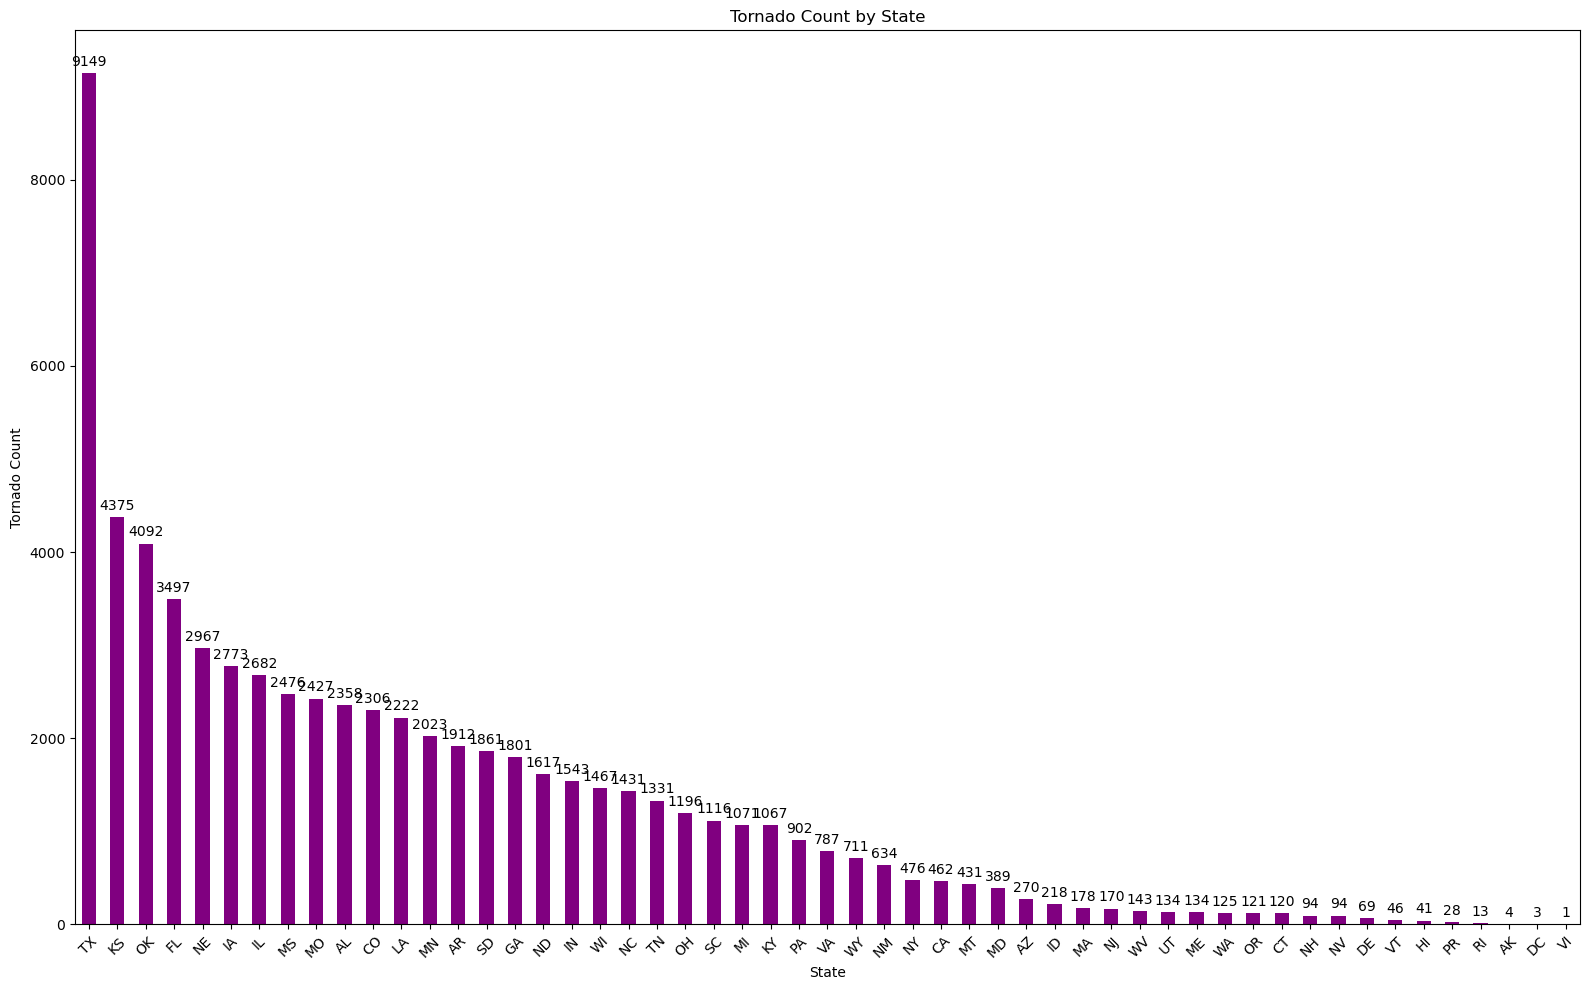

In [43]:
state_counts = norm_tornado_data['state'].value_counts()

plt.figure(figsize=[16,10])
bars = state_counts.plot(kind='bar', color='purple')

# Annotate each bar with its count
for bar in bars.patches:
    height = bar.get_height()
    plt.annotate('{}'.format(int(height)),  # Convert height to integer for annotation
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.xlabel('State')
plt.ylabel('Tornado Count')
plt.title('Tornado Count by State')
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

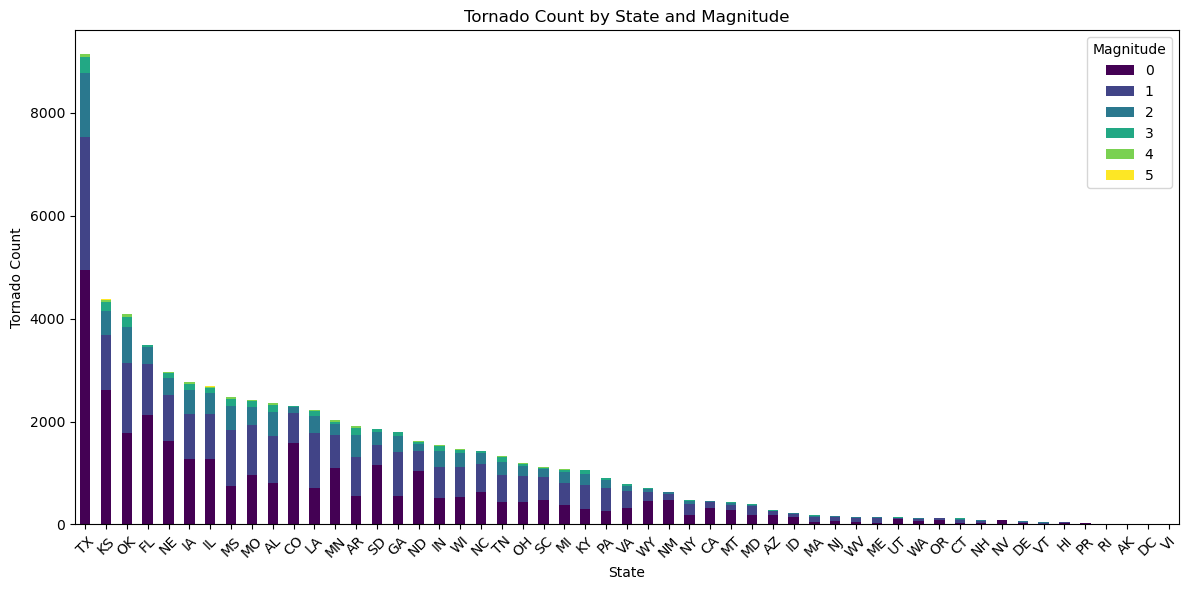

In [44]:
state_magnitude = norm_tornado_data.groupby(['state', 'magnitude']).size().unstack(fill_value=0)

state_magnitude_sorted = state_magnitude.sum(axis=1).sort_values(ascending=False)
state_magnitude_sorted = state_magnitude.loc[state_magnitude_sorted.index]

fig, ax = plt.subplots(figsize=(12, 6))
state_magnitude_sorted.plot(kind='bar', stacked=True, cmap='viridis', ax=ax)
ax.set_xlabel('State')
ax.set_ylabel('Tornado Count')
ax.set_title('Tornado Count by State and Magnitude')
ax.tick_params(axis='x', rotation=45)
ax.legend(title='Magnitude')
plt.tight_layout()
plt.show()

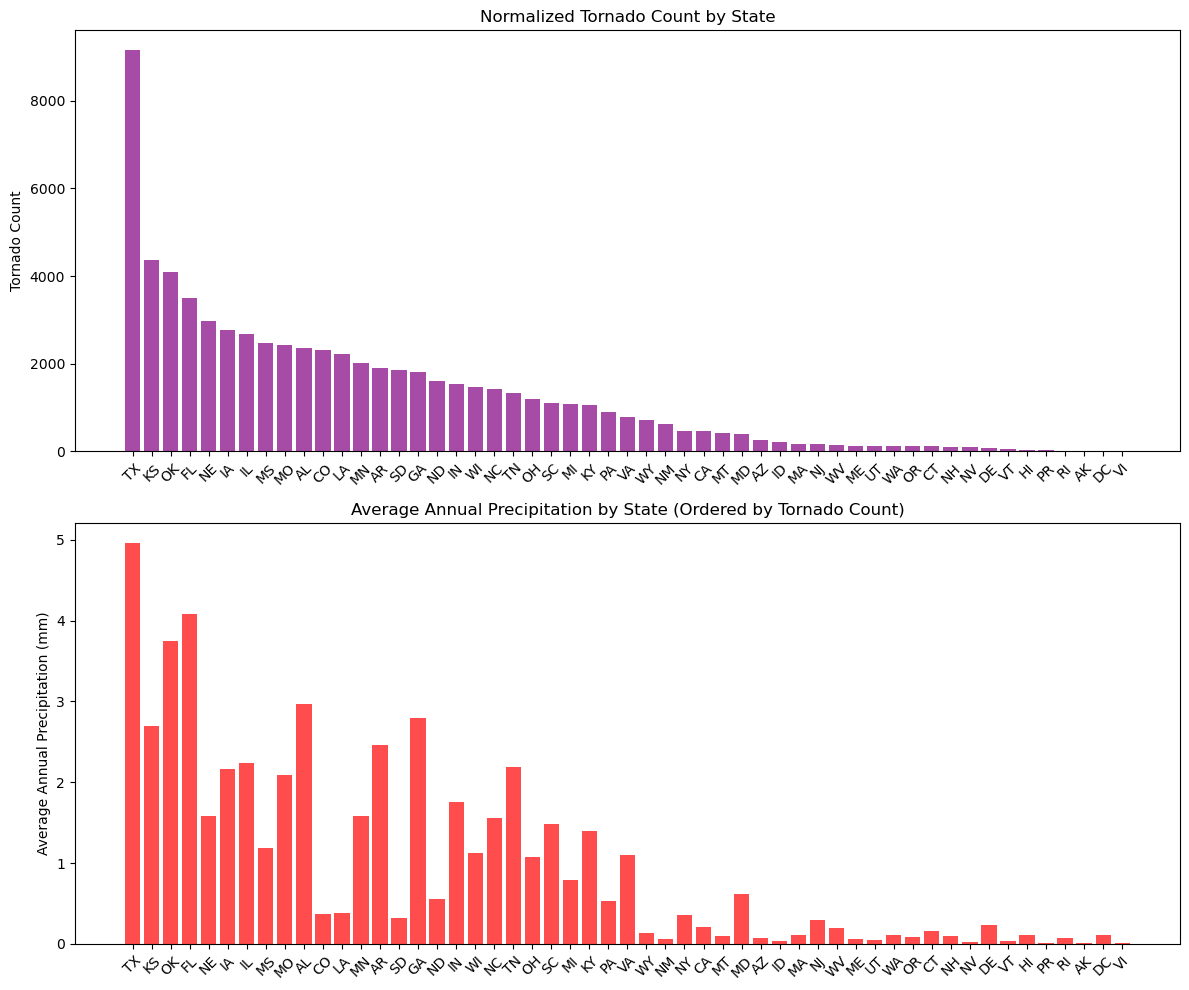

In [45]:
total_precipitation_per_state_year = norm_tornado_data.groupby(['state', 'state_encoded', 'year'])['precipitation_mm'].sum().reset_index()

average_annual_precipitation_per_state = total_precipitation_per_state_year.groupby(['state', 'state_encoded'])['precipitation_mm'].mean().reset_index(name='Average Annual Precipitation')
average_annual_precipitation_per_state = average_annual_precipitation_per_state.sort_values(by='Average Annual Precipitation', ascending=False)

tornado_count_per_state = tornado_data.groupby('state').size().reset_index(name='Tornado Count')
tornado_count_per_state = tornado_count_per_state.sort_values(by='Tornado Count', ascending=False)

merged_data = pd.merge(tornado_count_per_state, average_annual_precipitation_per_state, on='state', how='inner')

fig, axs = plt.subplots(2, 1, figsize=(12, 10))
axs[0].bar(merged_data['state'], merged_data['Tornado Count'], color='purple', alpha=0.7)
axs[0].set_ylabel('Tornado Count')
axs[0].set_title('Normalized Tornado Count by State')
axs[0].tick_params(axis='x', rotation=45)

axs[1].bar(merged_data['state'], merged_data['Average Annual Precipitation'], color='red', alpha=0.7)
axs[1].set_ylabel('Average Annual Precipitation (mm)')
axs[1].set_title('Average Annual Precipitation by State (Ordered by Tornado Count)')
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Correlation Analysis

In [46]:
drop_columns = ['state']
norm_tornado_data_2 = norm_tornado_data.drop(columns=drop_columns)

In [47]:
matrix = norm_tornado_data_2.corr()

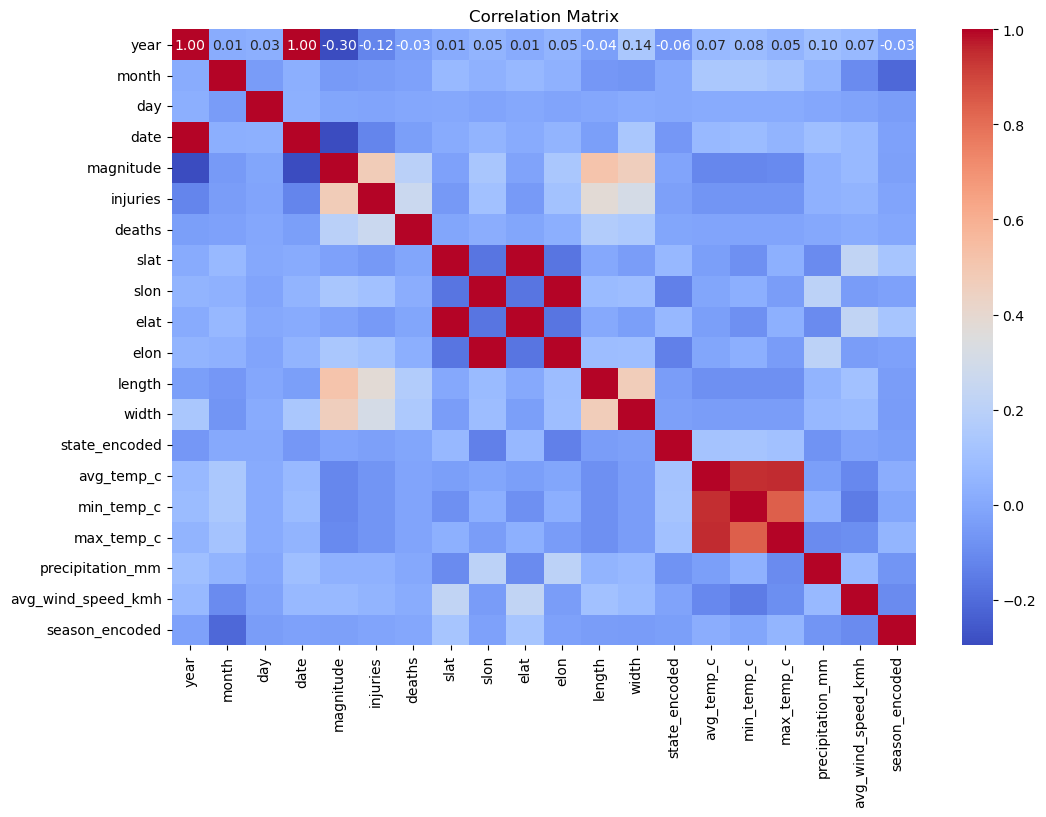

In [48]:
plt.figure(figsize=(12, 8))
sns.heatmap(matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

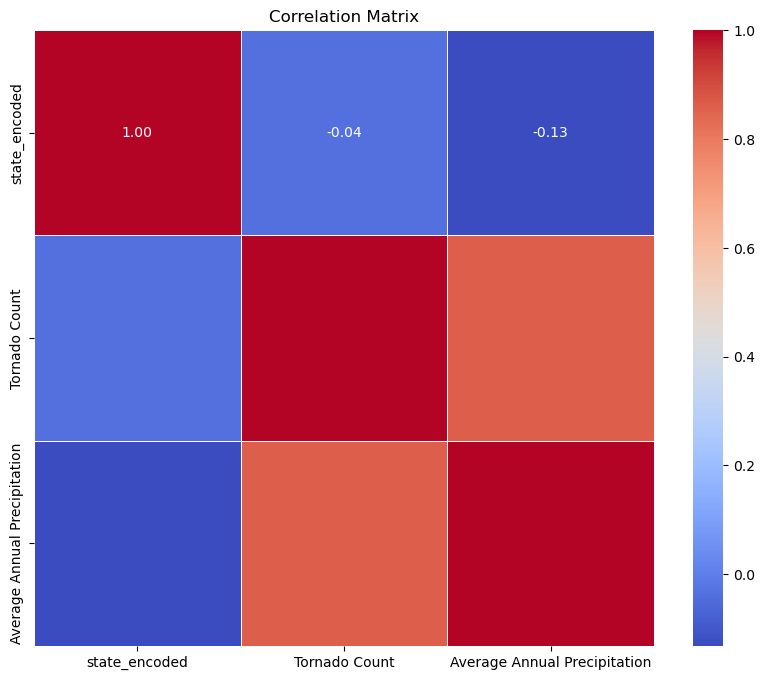

Correlation Coefficient: 0.8586144010097196


In [49]:
matrix = merged_data[['state_encoded', 'Tornado Count', 'Average Annual Precipitation']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

correlation_coefficient = merged_data['Tornado Count'].corr(merged_data['Average Annual Precipitation'])
print(f"Correlation Coefficient: {correlation_coefficient}")

# Model Building

## PCA

### Standardization

In [50]:
numeric_columns = ['state_encoded', 'avg_temp_c', 'min_temp_c', 'max_temp_c', 
                   'precipitation_mm', 'avg_wind_speed_kmh', 'season_encoded']

numeric_data = tornado_data[numeric_columns]

scaler = StandardScaler()
stan_tornado_data = scaler.fit_transform(numeric_data)

### Applying PCA

In [51]:
pca = PCA()
pca_tornado_data = pca.fit_transform(stan_tornado_data)

# Print explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [0.41065772 0.16402927 0.14842866 0.13015109 0.12431627 0.02022758
 0.00218941]


### Random Forest (RF) Regression 
RF regression is a technique where multiple decision trees are built during training, and the final prediction is the average (or weighted average) of the predictions from individual trees, offering robustness and improved accuracy for regression tasks compared to decision trees.

### Support Vector Regression (SVR)

Support Vector Regression is a regression algorithm that extends support vector machines to predict continuous outcomes by finding the hyperplane that maximizes the margin between data points while minimizing the prediction error, using kernel functions to capture non-linear relationships.

# Non-PCA Results

To analyze the weather and tornado data, the models that were used was a Random Forest Regression model and a Support Vector Regression model. I performed both models on the 3 depedent variables: magnitude, length, and width. These variables are factors that dictate the severity of a tornado and would previde the most insight from our data.

## Magnitude
### Random Forest Regression

Random Forest Regression is an ensemble learning technique that builds multiple decision trees during training and outputs the average prediction of individual trees to improve predictive accuracy and handle non-linear relationships in the data.

In [52]:
X = tornado_data[['state_encoded', 'avg_temp_c', 'min_temp_c', 'max_temp_c', 
                   'precipitation_mm', 'avg_wind_speed_kmh', 'season_encoded']]
y = tornado_data['magnitude']

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

# Initialize the Random Forest Regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=13)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

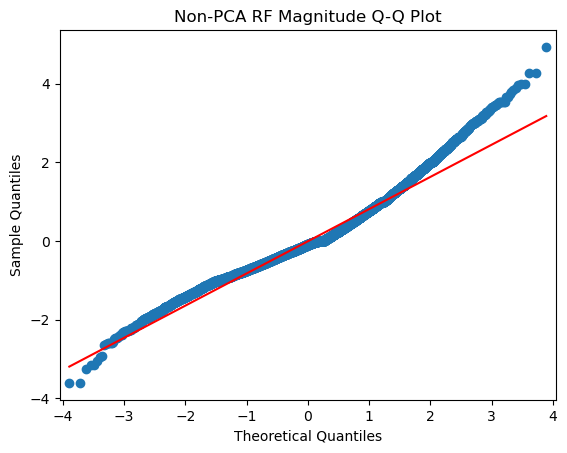

Mean Squared Error: 0.6699025527790586
Mean Absolute Error: 0.6151822762825617
R^2 Score: 0.1727009428878601


In [53]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Q-Q Plot
nonresiduals1 = y_test - y_pred
qqplot(nonresiduals1, line='s')
plt.title("Non-PCA RF Magnitude Q-Q Plot")
plt.show()

r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R^2 Score:", r2)

## Length
### Random Forest Regression

In [54]:
y = tornado_data['length']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)
rf_model = RandomForestRegressor(n_estimators=100, random_state=13)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

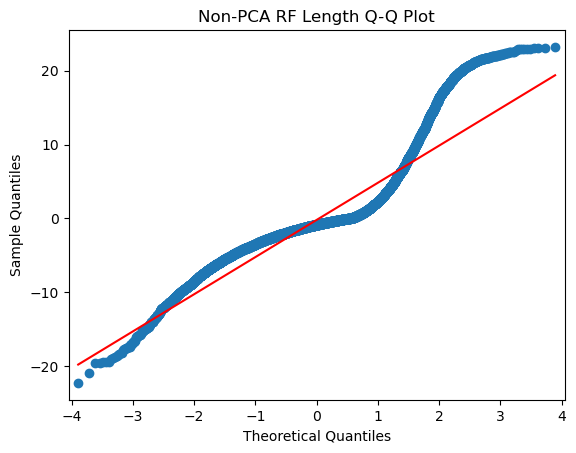

Mean Squared Error: 25.380892278073972
Mean Absolute Error: 3.179863617474517
R^2 Score: 0.04030294517869881


In [55]:
# Q-Q Plot
nonresiduals2 = y_test - y_pred
qqplot(nonresiduals2, line='s')
plt.title("Non-PCA RF Length Q-Q Plot")
plt.show()

r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R^2 Score:", r2)

## Width
### Random Forest Regression

In [56]:
y = tornado_data['width']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)
rf_model = RandomForestRegressor(n_estimators=100, random_state=13)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

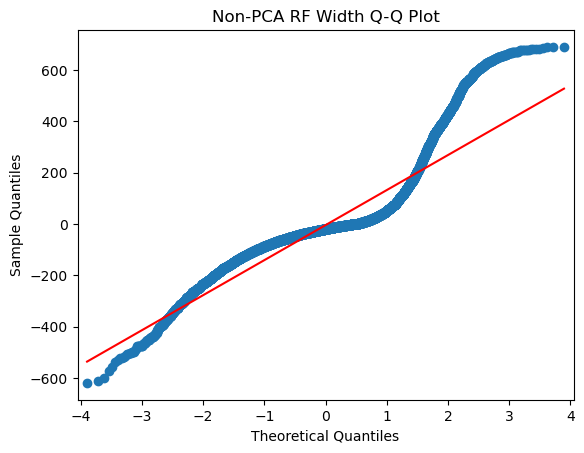

Mean Squared Error: 18663.434156204818
Mean Absolute Error: 82.08697955195959
R^2 Score: 0.10471220831146866


In [57]:
# Q-Q Plot
nonresiduals3 = y_test - y_pred
qqplot(nonresiduals3, line='s')
plt.title("Non-PCA RF Width Q-Q Plot")
plt.show()

r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R^2 Score:", r2)

## Magnitude
### SVR

In [58]:
y = tornado_data['magnitude']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

# Initialize with rbf kernel
svr_model = SVR(kernel='rbf') 

# Train the model
svr_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = svr_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

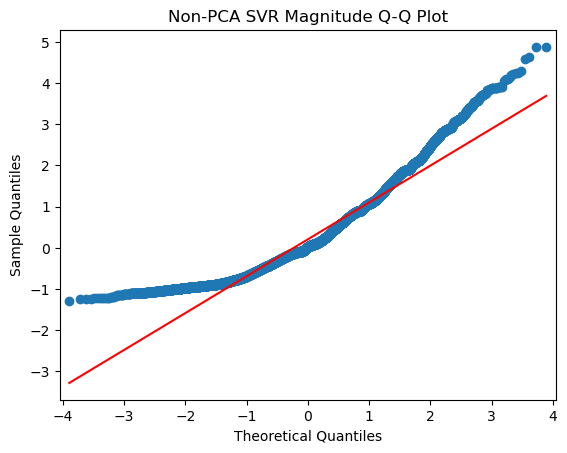

Mean Squared Error: 0.8424330580349866
Mean Absolute Error: 0.6862355329042915
R^2 Score: -0.0403663513464787


In [59]:
# Q-Q Plot
nonresiduals4 = y_test - y_pred
qqplot(nonresiduals4, line='s')
plt.title("Non-PCA SVR Magnitude Q-Q Plot")
plt.show()

r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R^2 Score:", r2)

## Length

### SVR

In [60]:
y = tornado_data['length']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train, y_train)
y_pred = svr_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

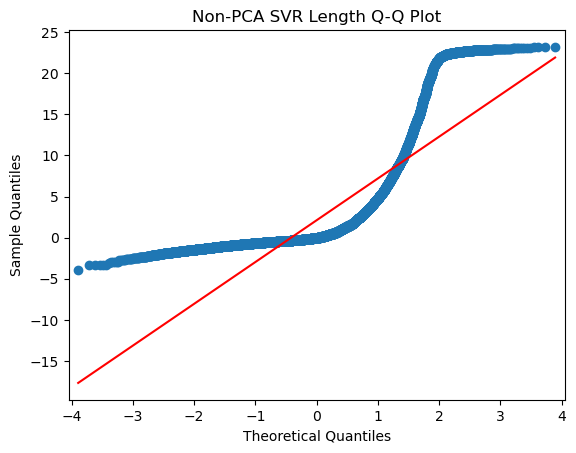

Mean Squared Error: 30.313893505300975
Mean Absolute Error: 2.705426616320089
R^2 Score: -0.14622267800789746


In [61]:
# Q-Q Plot
nonresiduals5 = y_test - y_pred
qqplot(nonresiduals5, line='s')
plt.title("Non-PCA SVR Length Q-Q Plot")
plt.show()

r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R^2 Score:", r2)

## Width

### SVR

In [62]:
y = tornado_data['width']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train, y_train)
y_pred = svr_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

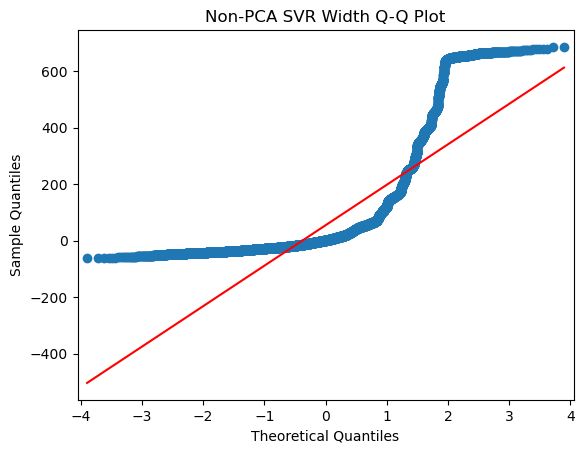

Mean Squared Error: 23469.184372304284
Mean Absolute Error: 76.21255568708924
R^2 Score: -0.12582036475992187


In [63]:
# Q-Q Plot
nonresiduals6 = y_test - y_pred
qqplot(nonresiduals6, line='s')
plt.title("Non-PCA SVR Width Q-Q Plot")
plt.show()

r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R^2 Score:", r2)

# PCA Results

## Magnitude
### Random Forest Regression

In [64]:
target_variable = tornado_data['magnitude']

# Split the PCA-transformed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pca_tornado_data, target_variable, test_size=0.3, random_state=13)

# Initialize and train the Random Forest Regression model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Predict on the testing set
y_pred = rf_regressor.predict(X_test)


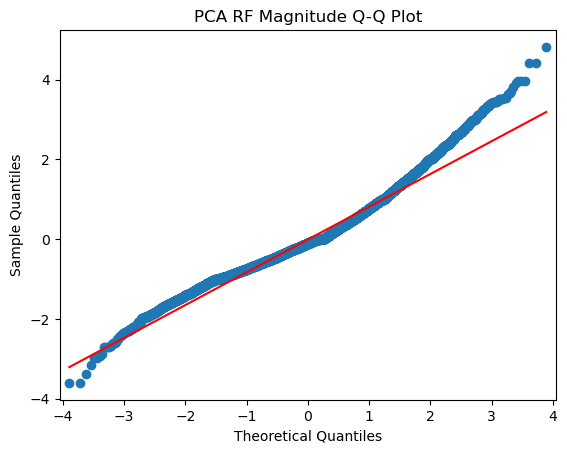

Mean Squared Error: 0.6756180323101976
Mean Absolute Error: 0.6215647587772983
R^2 Score: 0.16564258670241283


In [65]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Q-Q Plot
residuals1 = y_test - y_pred
qqplot(residuals1, line='s')
plt.title("PCA RF Magnitude Q-Q Plot")
plt.show()

r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R^2 Score:", r2)

## Length
### Random Forest Regression

In [66]:
target_variable = tornado_data['length']

# Split the PCA-transformed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pca_tornado_data, target_variable, test_size=0.3, random_state=13)

# Initialize and train the Random Forest Regression model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Predict on the testing set
y_pred = rf_regressor.predict(X_test)


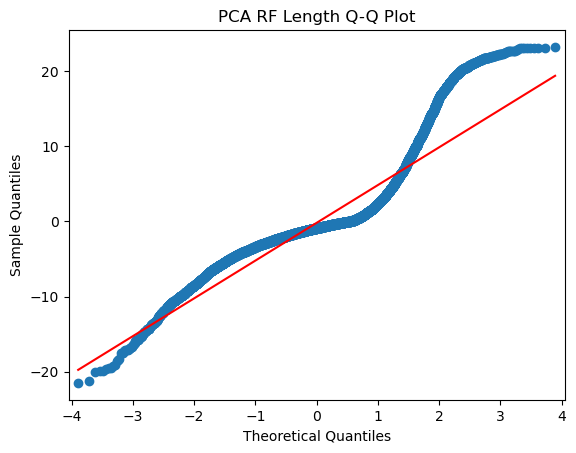

Mean Squared Error: 25.273979947103886
Mean Absolute Error: 3.1745436183813784
R^2 Score: 0.0443454921479679


In [67]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Q-Q Plot
residuals2 = y_test - y_pred
qqplot(residuals2, line='s')
plt.title("PCA RF Length Q-Q Plot")
plt.show()

r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R^2 Score:", r2)

## Width
### Random Forest Regression

In [68]:
y = tornado_data['width']

# Split the PCA-transformed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pca_tornado_data, y, test_size=0.3, random_state=13)

# Initialize and train the Random Forest Regression model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Predict on the testing set
y_pred = rf_regressor.predict(X_test)


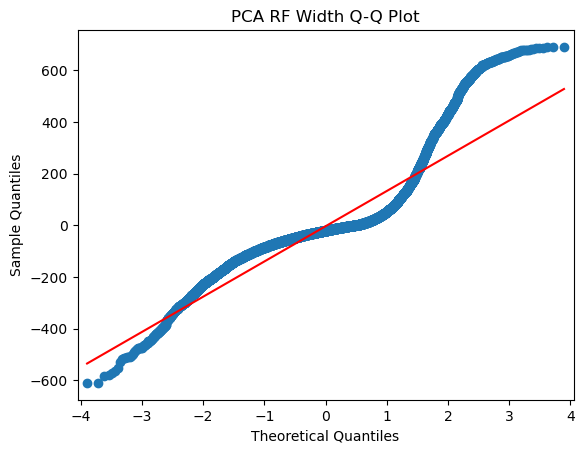

Mean Squared Error: 18628.166009757544
Mean Absolute Error: 82.28610360755454
R^2 Score: 0.10640402669202265


In [69]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Q-Q Plot
residuals3 = y_test - y_pred
qqplot(residuals3, line='s')
plt.title("PCA RF Width Q-Q Plot")
plt.show()

r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R^2 Score:", r2)

## Magnitude
### SVR

In [70]:
y = tornado_data['magnitude']
X_train, X_test, y_train, y_test = train_test_split(pca_tornado_data, y, test_size=0.3, random_state=13)

# Initialize with rbf kernel
svr_model = SVR(kernel='rbf') 

# Train the model
svr_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = svr_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

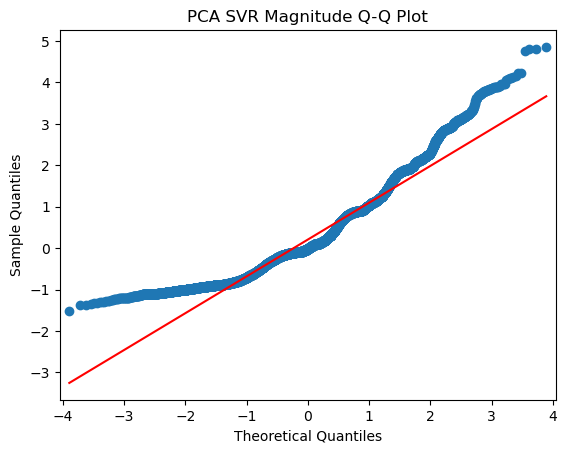

Mean Squared Error: 0.8313483403773891
Mean Absolute Error: 0.6732535019289065
R^2 Score: -0.02667723129694033


In [71]:
# Q-Q Plot
residuals4 = y_test - y_pred
qqplot(residuals4, line='s')
plt.title("PCA SVR Magnitude Q-Q Plot")
plt.show()

r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R^2 Score:", r2)

## Length
### SVR

In [72]:
y = tornado_data['length']
X_train, X_test, y_train, y_test = train_test_split(pca_tornado_data, y, test_size=0.3, random_state=13)

# Initialize with rbf kernel
svr_model = SVR(kernel='rbf') 

# Train the model
svr_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = svr_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

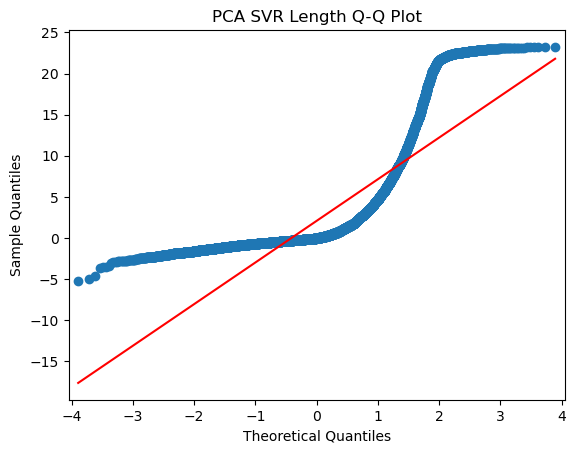

Mean Squared Error: 29.988924288700883
Mean Absolute Error: 2.6906254764803386
R^2 Score: -0.13393500913235856


In [73]:
# Q-Q Plot
residuals5 = y_test - y_pred
qqplot(residuals5, line='s')
plt.title("PCA SVR Length Q-Q Plot")
plt.show()

r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R^2 Score:", r2)

## Width
### SVR

In [74]:
y = tornado_data['width']
X_train, X_test, y_train, y_test = train_test_split(pca_tornado_data, y, test_size=0.3, random_state=13)

# Initialize with rbf kernel
svr_model = SVR(kernel='rbf') 

# Train the model
svr_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = svr_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

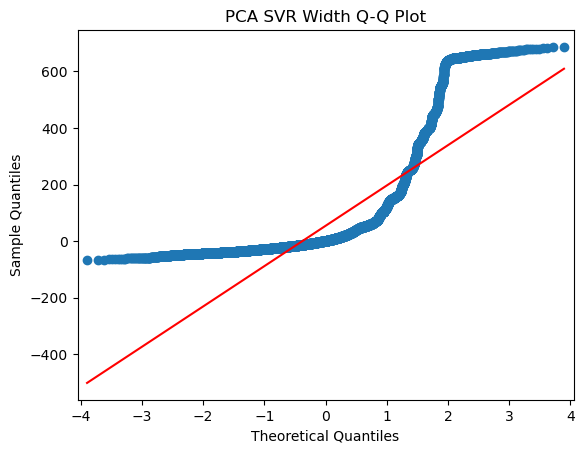

Mean Squared Error: 23281.51989570646
Mean Absolute Error: 75.71846755053076
R^2 Score: -0.11681807110777576


In [75]:
# Q-Q Plot
residuals6 = y_test - y_pred
qqplot(residuals6, line='s')
plt.title("PCA SVR Width Q-Q Plot")
plt.show()

r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R^2 Score:", r2)

## Final Results

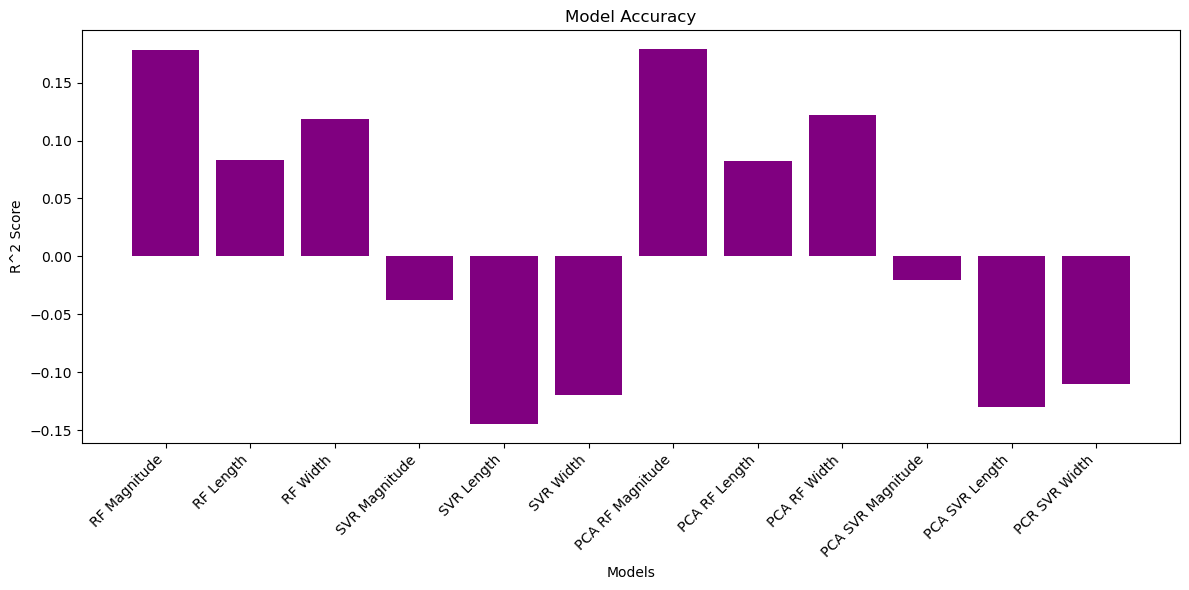

In [78]:
columns = ['RF Magnitude', 'RF Length', 'RF Width', 'SVR Magnitude', 'SVR Length', 'SVR Width', 'PCA RF Magnitude',
           'PCA RF Length', 'PCA RF Width', 'PCA SVR Magnitude', 'PCA SVR Length', 'PCR SVR Width']
data = [0.178, 0.083,0.119,-0.038,-0.145,-0.120,0.179,0.082,0.122,-0.02,-0.13,-0.110]

results = pd.DataFrame(data=[data], columns=columns)
plt.figure(figsize=(12, 6))
plt.bar(results.columns, results.iloc[0], color='purple')
plt.xlabel('Models')
plt.ylabel('R^2 Score')
plt.title('Model Accuracy')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Discussion

After testing the depdent variables into the Random Forest Regression model and Support Vector Regression models, I found the models to not perform very accurately on the data presented. I also found that when applying PCA, the model accuracy only improved marginally and not enough to consider the model efficient. Since there was a lot of data preprocessing to the weather data and it was done prior to the merge, the data could be providing inaccuraces causing the model to underperform. Also, it is relevant to state that the severity of a tornado is largely based off of its wind speed, and there is little research backing up weather conditions with tornadoes.

# Conclusion & Future Work

This research showed me the potential of merging datasets to find patterns within data as this was something I would normally stay away from. This study demonstrates the potential of using machine learning to predict tornado severity, but would require better weather data collection on the tornadoes themselves to get more accurate results. In the future, I would like expand the data to be global and look into the affects of location on the severity of a tornado.


In [77]:
###Luke Sullivan